### Notebook Description

**U-Net Image Segmentation**

This notebook is designed to implement and understand the U-Net architecture, a deep learning model widely used for image segmentation tasks. The notebook walks through the process of preparing the dataset, building the U-Net model, training it, and evaluating its performance.

**Objectives:**
1. Understand the fundamentals of image segmentation and why U-Net is a popular choice for this task.
2. Learn how to preprocess and split image datasets for training and testing.
3. Implement the U-Net architecture using PyTorch.
4. Train the model and visualize its predictions to evaluate its effectiveness.

**How to Use This Notebook:**
- The notebook is divided into sections such as data preparation, model definition, training, and evaluation.
- Each section contains code and comments explaining the purpose of the steps.
- Students are encouraged to complete the TODO sections, which guide them to implement missing parts of the code or analyze results.

**What You'll Learn:**
- Practical knowledge of handling image datasets.
- Building and customizing a U-Net model.
- Evaluating deep learning models for segmentation tasks.
- Gaining hands-on experience with PyTorch.

**Prerequisites:**
- Familiarity with Python and basic programming concepts.
- A basic understanding of deep learning and PyTorch.
- Knowledge of image processing concepts (optional but helpful).

**Tips for Success:**
- Follow the comments and instructions in the code.
- Refer to the provided links and resources to understand U-Net better.
- Experiment with the code to explore how changes affect the results.

---

This introduction can be added as a Markdown cell at the top of the notebook. Let me know if you'd like me to insert it into the notebook directly!

In [1]:
# This cell imports the required libraries and sets up the environment for the U-Net project.
# TODO for Students: Review these imports and identify which libraries are unfamiliar to you. Research their purpose.

# General libraries for file handling and image processing
import os
import PIL
import time
import glob
import torch
import pickle
import random

# Libraries for data manipulation and visualization
import torchvision
from torchvision import transforms
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Specific modules for image and path handling
from PIL import Image, ImageOps
from pathlib import Path
from sklearn.model_selection import train_test_split


## Data preparing

In [2]:
!gdown "https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ" -O dataset.tar.gz
!tar -xf dataset.tar.gz

Downloading...
From (original): https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ
From (redirected): https://drive.google.com/uc?id=1ffbbyoPf-I3Y0iGbBahXpWqYdGd7xxQQ&confirm=t&uuid=a2b0dc3a-4930-4702-a9cf-d43857fc52b8
To: /content/dataset.tar.gz
100% 4.40G/4.40G [01:16<00:00, 57.5MB/s]


In [3]:
# Specify the device to be used for computations.
# If a GPU is available, it will use GPU device 1 ("cuda:1"), otherwise it will fall back to the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data_folder = Path("dataset")
origins_folder = data_folder / "images"
masks_folder = data_folder / "masks"

In [71]:
class LungDataset(torch.utils.data.Dataset):
    """
    TODO:
    1. Implement a custom PyTorch Dataset for handling lung images and segmentation masks.
    2. Initialize with the list of image-mask pairs, the origins and masks folders, and optional transformations.
    """
    def __init__(self, origin_mask_list, origins_folder, masks_folder, transforms=None):
        """
        TODO: Initialize the dataset with:
        - `origin_mask_list`: List of (image_name, mask_name) pairs.
        - `origins_folder`: Path to the folder containing the original images.
        - `masks_folder`: Path to the folder containing the masks.
        - `transforms`: Optional transformations to apply.
        """
        self.origin_mask_list = origin_mask_list
        self.origins_folder = origins_folder
        self.masks_folder = masks_folder
        self.transforms = transforms

    def __getitem__(self, idx):
        """
        TODO:
        1. Retrieve the image and mask pair based on the provided index `idx`.
        2. Load the image and mask using `Image.open` and convert them if necessary.
        3. Apply the provided transformations if any.
        4. Normalize the image and convert the mask to a binary tensor.
        5. Return the preprocessed image and mask tensors.
        """
        image_name, mask_name = self.origin_mask_list[idx]

        image_path = f"{self.origins_folder}/{image_name}.png"
        mask_path = f"{self.masks_folder}/{mask_name}.png"
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transforms:
            image, mask = self.transforms((image, mask))

        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask)
        mask = (mask > 0).float()

        return image, mask

    def __len__(self):
        """
        TODO: Return the total number of image-mask pairs in the dataset.
        """
        return len(self.origin_mask_list)


class Pad():
    """
    TODO:
    1. Create a transformation to add random padding to the image and mask.
    2. Initialize with `max_padding` to control the maximum padding size.
    """
    def __init__(self, max_padding):
        self.max_padding = max_padding

    def __call__(self, sample):
        """
        TODO:
        1. Add random padding within the range of `max_padding`.
        2. Ensure the padding is consistent for both the image and the mask.
        3. Experiment with different padding styles or fill values.
        """
        image, mask = sample

        padding = [
            random.randint(0, self.max_padding),
            random.randint(0, self.max_padding),
            random.randint(0, self.max_padding),
            random.randint(0, self.max_padding),
        ]
        image = transforms.functional.pad(image, padding, fill=0)
        mask = transforms.functional.pad(mask, padding, fill=0)

        return image, mask


class Crop():
    """
    TODO:
    1. Implement a random cropping transformation for images and masks.
    2. Initialize with `max_shift` to control the maximum cropping shift.
    """
    def __init__(self, max_shift):
        self.max_shift = max_shift

    def __call__(self, sample):
        """
        TODO:
        1. Apply random cropping based on top-left and bottom-right shifts.
        2. Ensure the crop dimensions are consistent for both image and mask.
        3. Validate that the cropped dimensions are appropriate.
        """
        image, mask = sample
        width, height = image.size

        left_shift = random.randint(0, self.max_shift)
        top_shift = random.randint(0, self.max_shift)
        right_shift = random.randint(0, self.max_shift)
        bottom_shift = random.randint(0, self.max_shift)

        left = left_shift
        top = top_shift
        right = width - right_shift
        bottom = height - bottom_shift

        # Ensure valid crop dimensions
        right = max(right, left + 1)
        bottom = max(bottom, top + 1)

        image = transforms.functional.crop(image, top, left, bottom - top, right - left)
        mask = transforms.functional.crop(mask, top, left, bottom - top, right - left)

        return image, mask



class Resize():
    """
    TODO:
    1. Implement a transformation to resize the image and mask to a specific output size.
    2. Initialize with `output_size` as a tuple (height, width).
    """
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        """
        TODO:
        1. Resize both the image and the mask to the specified output size.
        2. Ensure no distortions occur during resizing unless intentional.
        """
        image, mask = sample

        image = transforms.functional.resize(image, self.output_size)
        mask = transforms.functional.resize(mask, self.output_size, interpolation=transforms.InterpolationMode.NEAREST)

        return image, mask


def blend(origin, mask1=None, mask2=None):
    """
    TODO:
    1. Create a visualization function to blend the original image with one or two masks.
    2. Convert the image tensor back to a PIL image for visualization.
    3. Blend the masks with different colors and transparency levels.
    """
    origin = transforms.ToPILImage()(origin)

    # Convert masks to RGB for blending
    if mask1 is not None:
        mask1 = transforms.ToPILImage()(mask1.squeeze(0)).convert("L")
        mask1 = ImageOps.colorize(mask1, black="black", white="green").convert("RGBA")
        mask1 = Image.blend(origin.convert("RGBA"), mask1, alpha=0.5)  # Lower transparency for mask1

    if mask2 is not None:
        mask2 = transforms.ToPILImage()(mask2.squeeze(0)).convert("L")
        mask2 = ImageOps.colorize(mask2, black="black", white="red").convert("RGBA")
        mask2 = Image.blend(origin.convert("RGBA"), mask2, alpha=0.5)  # Higher transparency for mask2

    if mask1 and mask2:
        blended = Image.blend(mask1, mask2, alpha=0.5)
    elif mask1:
        blended = mask1
    elif mask2:
        blended = mask2
    else:
        blended = origin

    return blended


In [5]:
batch_size = 4  # Batch size for training
origins_list = [f.stem for f in origins_folder.glob("*.png")]  # List of image file names
masks_list = [f.stem for f in masks_folder.glob("*.png")]  # List of mask file names
print(len(origins_list))  # Number of images
print(len(masks_list))  # Number of masks

800
704


In [6]:
# Create a list of tuples linking masks to their corresponding images.
origin_mask_list = [(mask_name.replace("_mask", ""), mask_name) for mask_name in masks_list]

# Split data into training, validation, and testing sets.
splits = {}
splits["train"], splits["test"] = train_test_split(origin_mask_list, test_size=0.2, random_state=42)
splits["train"], splits["val"] = train_test_split(splits["train"], test_size=0.1, random_state=42)

In [7]:
# TODO: Implement the validation and testing transformations.
val_test_transforms = torchvision.transforms.Compose([
    Resize((256, 256))
])

# TODO: Implement the training transformations by including padding, cropping, and resizing.
train_transforms = torchvision.transforms.Compose([
    Pad(max_padding=20),
    Crop(max_shift=10),
    Resize((256, 256)),
])

# TODO: Create the datasets for training, validation, and testing.
datasets = {
    "train": LungDataset(
        splits["train"], origins_folder=origins_folder, masks_folder=masks_folder, transforms=train_transforms
    ),
    "val": LungDataset(
        splits["val"], origins_folder=origins_folder, masks_folder=masks_folder, transforms=val_test_transforms
    ),
    "test": LungDataset(
        splits["test"], origins_folder=origins_folder, masks_folder=masks_folder, transforms=val_test_transforms
    )
}

# TODO: Initialize the dataloaders for each dataset.
dataloaders = {
    "train": torch.utils.data.DataLoader(datasets["train"], batch_size=16, shuffle=True, num_workers=2),
    "val": torch.utils.data.DataLoader(datasets["val"], batch_size=16, shuffle=False, num_workers=2),
    "test": torch.utils.data.DataLoader(datasets["test"], batch_size=16, shuffle=False, num_workers=2),
}



## Check datasets

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


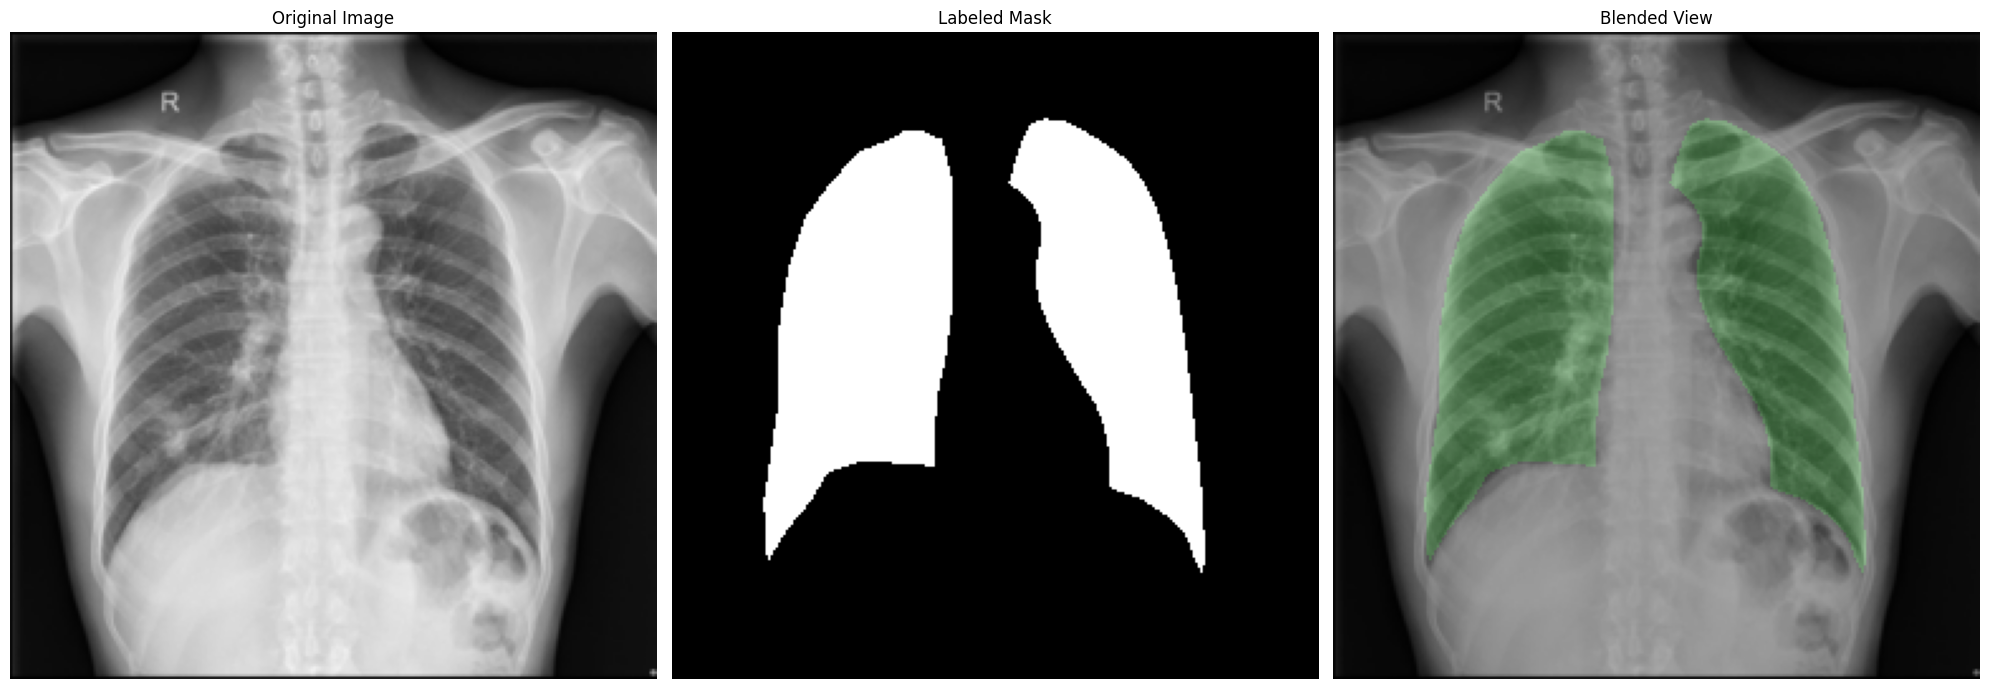

In [41]:
idx = 10
phase = "train"

plt.figure(figsize=(20, 10))
origin, mask = datasets[phase][idx]

# TODO: Convert the origin and mask tensors to PIL images for visualization.
pil_origin = transforms.ToPILImage()(origin)
pil_mask = transforms.ToPILImage()(mask.squeeze(0))  # Remove the channel dimension from the mask

plt.subplot(1, 3, 1)
plt.imshow(pil_origin)
plt.title("Original Image")
plt.axis("off")

# TODO: Plot the manually labeled mask.
plt.subplot(1, 3, 2)
plt.imshow(pil_mask, cmap="gray")
plt.title("Labeled Mask")
plt.axis("off")

# TODO: Plot the blended view of the original image and mask.
print(origin.shape, mask.shape)
blended = blend(origin, mask)
plt.subplot(1, 3, 3)
plt.imshow(blended)
plt.title("Blended View")
plt.axis("off")

plt.tight_layout()
plt.show()

## Unet Architecture

In [9]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, batch_norm=False):
        super().__init__()
        # TODO: Define the first convolutional layer
        self.conv1 = torch.nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        # TODO: Define the second convolutional layer
        self.conv2 = torch.nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1)

        self.batch_norm = batch_norm
        if batch_norm:
            # TODO: Define batch normalization layers
            self.bn1 = torch.nn.BatchNorm2d(mid_channels)
            self.bn2 = torch.nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # TODO: Apply the first convolutional layer and batch normalization (if enabled)
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = torch.nn.ReLU()(x)

        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = torch.nn.ReLU()(x)
        return x


class UNet(torch.nn.Module):
    def up(self, x, size):
        # TODO: Implement upsampling
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)

    def down(self, x):
        # TODO: Implement max pooling for downsampling
        return torch.nn.functional.max_pool2d(x, kernel_size=2)

    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        # TODO: Define encoder blocks
        self.enc1 = Block(in_channels, 64, 64, batch_norm=batch_norm)
        self.enc2 = Block(64, 128, 128, batch_norm=batch_norm)
        self.enc3 = Block(128, 256, 256, batch_norm=batch_norm)
        self.enc4 = Block(256, 512, 512, batch_norm=batch_norm)

        # TODO: Define center block
        self.center = Block(512, 1024, 512, batch_norm=batch_norm)

        # TODO: Define decoder blocks
        self.dec4 = Block(1024, 512, 256, batch_norm=batch_norm)
        self.dec3 = Block(512, 256, 128, batch_norm=batch_norm)
        self.dec2 = Block(256, 128, 64, batch_norm=batch_norm)
        self.dec1 = Block(128, 64, 64, batch_norm=batch_norm)

        # TODO: Define final output layer
        self.out = torch.nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # TODO: Implement forward pass for UNet
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.down(enc1))
        enc3 = self.enc3(self.down(enc2))
        enc4 = self.enc4(self.down(enc3))

        # Center
        center = self.center(self.down(enc4))

        # Decoder
        dec4 = self.dec4(torch.cat([self.up(center, enc4.shape[2:]), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.up(dec4, enc3.shape[2:]), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.up(dec3, enc2.shape[2:]), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.up(dec2, enc1.shape[2:]), enc1], dim=1))

        # Final output
        return self.out(dec1)



In [10]:
class PretrainedUNet(torch.nn.Module):
    def up(self, x, size):
        # TODO: Implement upsampling
        return torch.nn.functional.interpolate(x, size=size, mode=self.upscale_mode)

    def down(self, x):
        # TODO: Implement max pooling for downsampling
        return torch.nn.functional.max_pool2d(x, kernel_size=2)


    def __init__(self, in_channels, out_channels, batch_norm=False, upscale_mode="nearest"):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.batch_norm = batch_norm
        self.upscale_mode = upscale_mode

        # TODO: Define initial convolution layer to adjust input channels
        self.init_conv = torch.nn.Conv2d(in_channels, 3, kernel_size=1)

        # TODO: Extract pretrained VGG-11 encoder layers
        vgg11 = models.vgg11(pretrained=True).features

        self.conv1 = vgg11[0]  # Conv layer 1
        self.conv2 = vgg11[3]  # Conv layer 2
        self.conv3 = vgg11[6]  # Conv layer 3
        self.conv3s = vgg11[8]  # Conv layer 3 second stage
        self.conv4 = vgg11[11]  # Conv layer 4
        self.conv4s = vgg11[13]  # Conv layer 4 second stage
        self.conv5 = vgg11[16]  # Conv layer 5
        self.conv5s = vgg11[18] # Conv layer 5 second stage

        # TODO: Define center and decoder blocks
        self.center = Block(512, 512, 256, batch_norm=batch_norm)
        self.dec5 = Block(768, 512, 256, batch_norm=batch_norm)
        self.dec4 = Block(768, 512, 128, batch_norm=batch_norm)
        self.dec3 = Block(384, 256, 64, batch_norm=batch_norm)
        self.dec2 = Block(192, 128, 32, batch_norm=batch_norm)
        self.dec1 = Block(96, 64, 32, batch_norm=batch_norm)

        # TODO: Define final output layer
        self.out = torch.nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # TODO: Implement forward pass for Pretrained UNet
        x = self.init_conv(x)
        x1 = self.conv1(x)
        x2 = self.conv2(self.down(x1))
        x3 = self.conv3(self.down(x2))
        x3s = self.conv3s(x3)
        x4 = self.conv4(self.down(x3s))
        x4s = self.conv4s(x4)
        x5 = self.conv5(self.down(x4s))
        x5s = self.conv5s(x5)


        # print("x5s down: ", self.down(x5s).shape)
        # Center
        center = self.center(self.down(x5s))
        # print("center: ", center.shape)

        # Decoder
        dec5 = self.dec5(torch.cat([self.up(center, x5s.size()[2:]), x5s], dim=1))
        dec4 = self.dec4(torch.cat([self.up(dec5, x4s.size()[2:]), x4s], dim=1))
        dec3 = self.dec3(torch.cat([self.up(dec4, x3s.size()[2:]), x3s], dim=1))
        dec2 = self.dec2(torch.cat([self.up(dec3, x2.size()[2:]), x2], dim=1))
        dec1 = self.dec1(torch.cat([self.up(dec2, x1.size()[2:]), x1], dim=1))

        # Output layer
        out = self.out(dec1)
        return out


In [11]:
# TODO: Initialize the PretrainedUNet model with appropriate parameters.
unet = PretrainedUNet(
    in_channels=3,         # Assuming RGB images as input (3 channels).
    out_channels=1,        # Single output channel for binary segmentation.
    batch_norm=True,       # Enable batch normalization for better training stability.
    upscale_mode="bilinear" # Use bilinear interpolation for upsampling.
)

# TODO: Move the model to the appropriate device (CPU or GPU).
unet = unet.to(device)

# TODO: Print the model to verify its structure.
unet


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:04<00:00, 132MB/s]


PretrainedUNet(
  (init_conv): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3s): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5s): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (center): Block(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchN

## Helper functions

In [12]:
def jaccard(y_true, y_pred):
    """Calculate Jaccard Index (IoU) for a batch of images."""
    num = y_true.size(0)  # Batch size
    eps = 1e-7  # Small constant to prevent division by zero

    # Flatten the tensors for pixel-wise comparison
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)

    # Calculate intersection and union
    intersection = (y_true_flat * y_pred_flat).sum(1)
    union = ((y_true_flat + y_pred_flat) > 0.0).float().sum(1)

    # Compute Jaccard score
    score = intersection / (union + eps)
    return score.sum() / num  # Average score over batch


def dice(y_true, y_pred):
    """Calculate Dice coefficient (F1 score) for a batch of images."""
    num = y_true.size(0)  # Batch size
    eps = 1e-7  # Small constant to prevent division by zero

    # Flatten the tensors for pixel-wise comparison
    y_true_flat = y_true.view(num, -1)
    y_pred_flat = y_pred.view(num, -1)

    # Calculate intersection
    intersection = (y_true_flat * y_pred_flat).sum(1)

    # Compute Dice score
    score = (2 * intersection) / (y_true_flat.sum(1) + y_pred_flat.sum(1) + eps)
    return score.sum() / num  # Average score over batch


## Training

In [19]:
# TODO: Set training configurations such as log file, epochs, and optimizer.
train_log_filename = "training_log.txt"  # TODO: Specify log file name
epochs = 25  # TODO: Define the number of epochs
best_val_loss = np.inf
model_name = "best_unet_model.pth"  # TODO: Specify model checkpoint name
optimizer =  torch.optim.Adam(unet.parameters(), lr=1e-4)  # TODO: Initialize optimizer (e.g., Adam)
criterion = torch.nn.BCEWithLogitsLoss()

# TODO: Initialize history list to store training and validation metrics.
hist = []

# Training loop
for e in range(epochs):
    start_t = time.time()  # Track the start time of the epoch.

    # Training phase
    print("train phase")
    unet.train()
    train_loss = 0.0
    for origins, masks in dataloaders["train"]:
        num = origins.size(0)  # Batch size

        # TODO: Move input data and targets to the device (CPU or GPU).
        origins = origins.to(device)
        masks = masks.to(device)

        # TODO: Reset gradients and perform forward and backward passes.
        optimizer.zero_grad()
        outputs = unet(origins)

        # print("masks:", masks[0])
        # print("unet putputs:", outputs[0])


        loss = criterion(outputs, masks)
        print("loss:", loss.item())
        loss.backward()
        optimizer.step()

        # TODO: Accumulate training loss for reporting.
        train_loss += loss.item() * num
        print(".", end="")  # Print progress

    train_loss = train_loss / len(datasets['train'])  # Normalize training loss
    print()

    # Validation phase
    print("validation phase")
    unet.eval()
    val_loss = 0.0
    val_jaccard = 0.0
    val_dice = 0.0

    for origins, masks in dataloaders["val"]:
        num = origins.size(0)  # Batch size

        # TODO: Move validation data and targets to the device.
        origins = origins.to(device)
        masks = masks.to(device)

        with torch.no_grad():  # Disable gradient computation for validation.
            outputs = unet(origins)  # Forward pass
            softmax_outputs = torch.nn.functional.softmax(outputs, dim=1)

            # print("valid:")
            # print(outputs[0])
            # print(softmax_outputs[0])

            val_loss += criterion(outputs, masks).item() * num

            # TODO: Compute Jaccard and Dice metrics for evaluation.
            # preds = torch.argmax(softmax_outputs, dim=1)
            preds = torch.sigmoid(outputs) > 0.5  # Binarize predictions

            # Compute Jaccard and Dice metrics
            val_jaccard += jaccard(masks, preds) * num
            val_dice += dice(masks, preds) * num
            print("val_dice: ",val_dice)
            print("val_jaccard: ",val_jaccard)


        print(".", end="")  # Print progress

    val_loss = val_loss / len(datasets['val'])
    val_jaccard = val_jaccard / len(datasets['val'])
    val_dice = val_dice / len(datasets['val'])
    print()

    end_t = time.time()  # Track the end time of the epoch.
    spended_t = end_t - start_t

    # TODO: Log training and validation metrics.
    with open(train_log_filename, "a") as train_log_file:
        report = (
            f"Epoch {e + 1}/{epochs}, Time: {spended_t:.2f}s, "
            f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
            f"Jaccard: {val_jaccard:.4f}, Dice: {val_dice:.4f}"
        )

        # Append metrics to the history list
        hist.append({
            "time": spended_t,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_jaccard": val_jaccard,
            "val_dice": val_dice,
        })

        print(report)  # Print the metrics
        train_log_file.write(report + "\n")  # Write metrics to the log file
        print()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(unet.state_dict(), model_name)
        print(f"Saved new best model with Val Loss: {val_loss:.4f}")


train phase
loss: 0.43732818961143494
.loss: 0.40766286849975586
.loss: 0.38741832971572876
.loss: 0.3625735640525818
.loss: 0.35596346855163574
.loss: 0.34522902965545654
.loss: 0.325390487909317
.loss: 0.31567591428756714
.loss: 0.3130838871002197
.loss: 0.3112591803073883
.loss: 0.30121558904647827
.loss: 0.2979612648487091
.loss: 0.2966514825820923
.loss: 0.28881722688674927
.loss: 0.29138684272766113
.loss: 0.2953090965747833
.loss: 0.278963178396225
.loss: 0.27884721755981445
.loss: 0.2834288775920868
.loss: 0.2689281105995178
.loss: 0.27809345722198486
.loss: 0.2646573781967163
.loss: 0.2676607668399811
.loss: 0.2629314064979553
.loss: 0.26407590508461
.loss: 0.26299408078193665
.loss: 0.25861209630966187
.loss: 0.25900205969810486
.loss: 0.2670179605484009
.loss: 0.25818872451782227
.loss: 0.2657041549682617
.loss: 0.26129254698753357
.
validation phase
val_dice:  tensor(14.4238, device='cuda:0')
val_jaccard:  tensor(13.1543, device='cuda:0')
.val_dice:  tensor(28.8811, device=

train phase
...............................................................................................................................
validation phase
...............
epoch: 1/20, time: 189.78534531593323, train loss: 0.19653227672039755, 
val loss: 0.12217853335957778, val jaccard: 0.8884699992966234, val dice: 0.9397114755814535

train phase
...............................................................................................................................
validation phase
...............
epoch: 2/20, time: 181.92755842208862, train loss: 0.10587698341947299, 
val loss: 0.11545559097277491, val jaccard: 0.8549241183096903, val dice: 0.9192221321557698

train phase
...............................................................................................................................
validation phase
...............
epoch: 3/20, time: 181.40333032608032, train loss: 0.081280764987464, 
val loss: 0.09347013057323925, val jaccard: 0.8818085643283108, val dice: 0.

Overall Training Time: 52.86 minutes
Mean Epoch Time: 2.30 minutes
Final Training Loss: 0.1114
Final Validation Loss: 0.1172
Final Validation Dice: 0.9573
Final Validation Jaccard: 0.9193


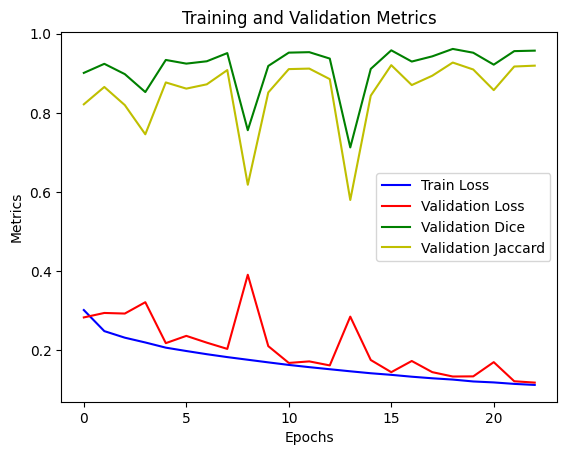

In [25]:
train_loss_hist = [h["train_loss"] for h in hist[:23]]  # Extract training loss from `hist`.
plt.plot(range(len(train_loss_hist)), train_loss_hist, "b", label="Train Loss")

# Extract and plot validation loss history
val_loss_hist = [h["val_loss"] for h in hist[:23]]  # Extract validation loss from `hist`.
plt.plot(range(len(val_loss_hist)), val_loss_hist, "r", label="Validation Loss")

# Extract and plot Dice score history
val_dice_hist = [h["val_dice"].cpu().numpy() if isinstance(h["val_dice"], torch.Tensor) else h["val_dice"] for h in hist[:23]]
plt.plot(range(len(val_dice_hist)), val_dice_hist, "g", label="Validation Dice")

# Extract and plot Jaccard score history
val_jaccard_hist = [h["val_jaccard"].cpu().numpy() if isinstance(h["val_jaccard"], torch.Tensor) else h["val_jaccard"] for h in hist[:23]]
plt.plot(range(len(val_jaccard_hist)), val_jaccard_hist, "y", label="Validation Jaccard")

# Add labels and legend to the plot
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Training and Validation Metrics")

# Compute overall training time and mean epoch time
time_hist = [h["time"] for h in hist[:23]]  # Extract time per epoch from `hist`.
overall_time = sum(time_hist) / 60  # Calculate total training time in minutes.
mean_epoch_time = overall_time / len(hist[:23])  # Calculate mean epoch time in minutes.

# Print summary of training statistics
print(f"Overall Training Time: {overall_time:.2f} minutes")
print(f"Mean Epoch Time: {mean_epoch_time:.2f} minutes")
print(f"Final Training Loss: {train_loss_hist[-1]:.4f}")
print(f"Final Validation Loss: {val_loss_hist[-1]:.4f}")
print(f"Final Validation Dice: {val_dice_hist[-1]:.4f}")
print(f"Final Validation Jaccard: {val_jaccard_hist[-1]:.4f}")

plt.show()

## Test

In [29]:
# Load the best model
best_unet = PretrainedUNet(
    in_channels=3,         # Assuming RGB images as input (3 channels).
    out_channels=1,        # Single output channel for binary segmentation.
    batch_norm=True,       # Enable batch normalization for better training stability.
    upscale_mode="bilinear" # Use bilinear interpolation for upsampling.
)
best_unet.to(device)  # Move the model to the correct device

# Load the saved state dictionary into the model
checkpoint = torch.load("best_unet_model.pth", map_location=device)
best_unet.load_state_dict(checkpoint)

<ipython-input-29-b727c0fef80d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_unet_model.pth", map_location=device)


<All keys matched successfully>

In [35]:
# Set the model to evaluation mode
best_unet.eval()
test_loss = 0.0
test_jaccard = 0.0
test_dice = 0.0
criterion = torch.nn.BCEWithLogitsLoss()

# Iterate through the test dataloader
for origins, masks in dataloaders["test"]:
    num = origins.size(0)

    # Move data to the device
    origins = origins.to(device)
    masks = masks.to(device)

    with torch.no_grad():  # Disable gradient calculation for evaluation
        # Perform forward pass
        outs = best_unet(origins)

        # Apply log-softmax to the output
        softmax = torch.nn.functional.log_softmax(outs, dim=1)

        # Compute test loss
        test_loss += criterion(outs, masks).item() * num

        # Calculate Jaccard and Dice metrics
        preds = torch.sigmoid(outs) > 0.5
        # preds = torch.argmax(softmax, dim=1).float()  # Get class predictions
        masks = masks.float()  # Convert masks to float
        test_jaccard += jaccard(masks, preds) * num  # Multiply by batch size for total Jaccard
        test_dice += dice(masks, preds) * num  # Multiply by batch size for total Dice


    print(".", end="")  # Print progress

# Compute average metrics
test_loss = test_loss / len(datasets["test"])  # Average test loss
test_jaccard = test_jaccard / len(datasets["test"])  # Average Jaccard score
test_dice = test_dice / len(datasets["test"])  # Average Dice score

# Print the results
print()
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Jaccard: {test_jaccard:.4f}")
print(f"Test Dice: {test_dice:.4f}")


.........
Test Loss: 0.1197
Test Jaccard: 0.9136
Test Dice: 0.9537



red area - predict
green area - ground truth
yellow area - intersection


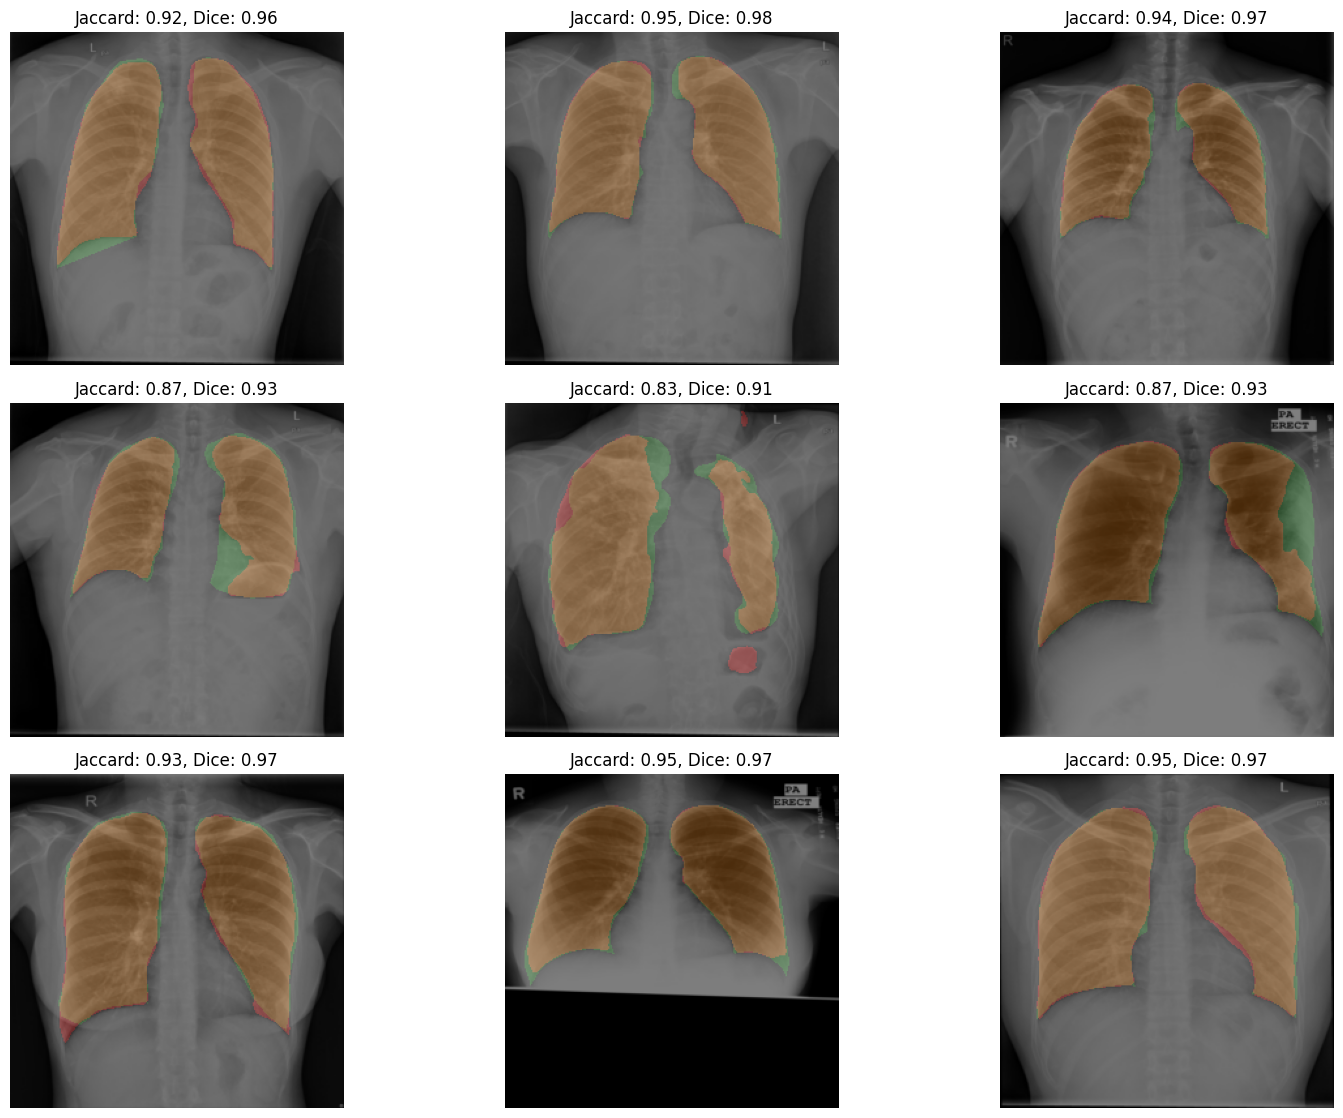

In [73]:
# Number of samples to visualize and the dataset phase.
num_samples = 9
phase = 'test'

# Create a subset of random samples from the specified phase.
random_indices = random.sample(range(len(datasets[phase])), num_samples)
subset = torch.utils.data.Subset(datasets[phase], random_indices)
random_samples_loader = torch.utils.data.DataLoader(subset, batch_size=1)

# Initialize the figure for visualization.
plt.figure(figsize=(15, 15))  # Define a larger figure size for better clarity.

# Iterate through the random samples.
for idx, (origin, mask) in enumerate(random_samples_loader):
    plt.subplot((num_samples // 3) + 1, 3, idx + 1)  # Set subplot grid dimensions.

    # Move the input data to the appropriate device.
    origin = origin.to(device)
    mask = mask.to(device)

    with torch.no_grad():  # Disable gradient computation for prediction.
        outs = best_unet(origin)  # Get predictions from the model


        preds = (torch.sigmoid(outs) > 0.5).int()
        # softmax = torch.nn.functional.softmax(outs, dim=1)
        # preds = torch.argmax(softmax, dim=1)

        # Compute evaluation metrics (Jaccard and Dice scores).
        jaccard_score = jaccard(mask, preds)
        dice_score = dice(mask, preds)

        # Move data back to the CPU for visualization.
        origin = origin.cpu().squeeze(0)
        out = preds.cpu().float()
        mask = mask.cpu().squeeze(0)

        # Visualize the blended output (prediction and ground truth).
        # print(origin.shape, mask.shape, out.shape)

        blended = blend(origin, mask, out)

        plt.imshow(blended)
        plt.title(f"Jaccard: {jaccard_score:.2f}, Dice: {dice_score:.2f}")
        plt.axis("off")

print()
print("red area - predict")
print("green area - ground truth")
print("yellow area - intersection")
plt.tight_layout()
plt.show()
